In [1]:
import numpy as np

import cv2
from PIL import Image

from matplotlib import pyplot as plt

import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.functional import sigmoid

import numpy as np

In [2]:
class EmojiDataset(Dataset):
    def __init__(self, rgb_images, transform=None):
        self.rgb_images = rgb_images  # (num, 224, 224, 3)
        self.transform = transform

    def __len__(self):
        return len(self.rgb_images)

    def __getitem__(self, idx):
        # Convert to PyTorch tensors
        rgb = torch.tensor(self.rgb_images[idx], dtype=torch.float32)

        # Permute from (H, W, C) → (C, H, W)
        rgb = rgb.permute(2, 0, 1)  # (3, 224, 224)
        # Normalize image pixels to [0,1]
        rgb /= 255.0

        if self.transform:
            rgb = self.transform(rgb)
        
        return rgb

The following template uses rgb only.

In [3]:
### Code to load the image 
IMG_SIZE = (224, 224)

# Open the image from the content using PIL
img = Image.open("sample.jpg")

# discovered that some images have an alpha (transparency) channel
if img.mode == "RGBA":
    img = img.convert("RGB")  # Convert RGBA → RGB
    
# Convert rgb image to numpy array
rgb_arr = np.array(img)

# Some images are grayscale by default
if len(rgb_arr.shape) == 2:  # Grayscale image
    rgb_arr = np.stack((rgb_arr,)*3, axis=-1)  # Convert (H,W) → (H,W,3)
    
rgb_arr = cv2.resize(rgb_arr, IMG_SIZE, interpolation=cv2.INTER_CUBIC) # upscale/interpolate for smaller images

rgb_list = []
rgb_list.append(rgb_arr)
rgb = np.array(rgb_list)  # Convert list to numpy array

sample_dataset = EmojiDataset(rgb, transform=None)
sample_loader = DataLoader(sample_dataset, batch_size=1, shuffle=False)

print(rgb.shape)

(1, 224, 224, 3)


In [4]:
rgb = sample_dataset[0]

print("Single image shape:", rgb.shape)  # Expected: (3, 224, 224)

Single image shape: torch.Size([3, 224, 224])


In [5]:
for rgb in sample_loader:
    print("Batch image shape:", rgb.shape)  # Expected: (1, 3, 224, 224)
    break

Batch image shape: torch.Size([1, 3, 224, 224])


In [6]:
top11 = [1381, 1424, 1392, 1447, 186, 1389, 1420, 1620, 1403, 1138, 1446]

def decode(v):
    res = []
    for i in range(len(v)):
        if v[i] == 1:
            res.append(top11[i])
    return res

In [7]:
model = models.efficientnet_b0(weights=None)
num_classes = 11  # Top 11
# Modify the last layer
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
model.load_state_dict(torch.load("efficientnet_b0_rgb_only.pth"))
model.eval()

model.eval()

threshold = 0.3
with torch.no_grad():
    for rgb in sample_loader:

        outputs = model(rgb)
        # Convert logits to probabilities
        probs = sigmoid(outputs)  
        # Convert logits to binary, 
        predicted = (probs > threshold)[0].int()
        
print(predicted)
print(decode(predicted))

tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)
[1392]


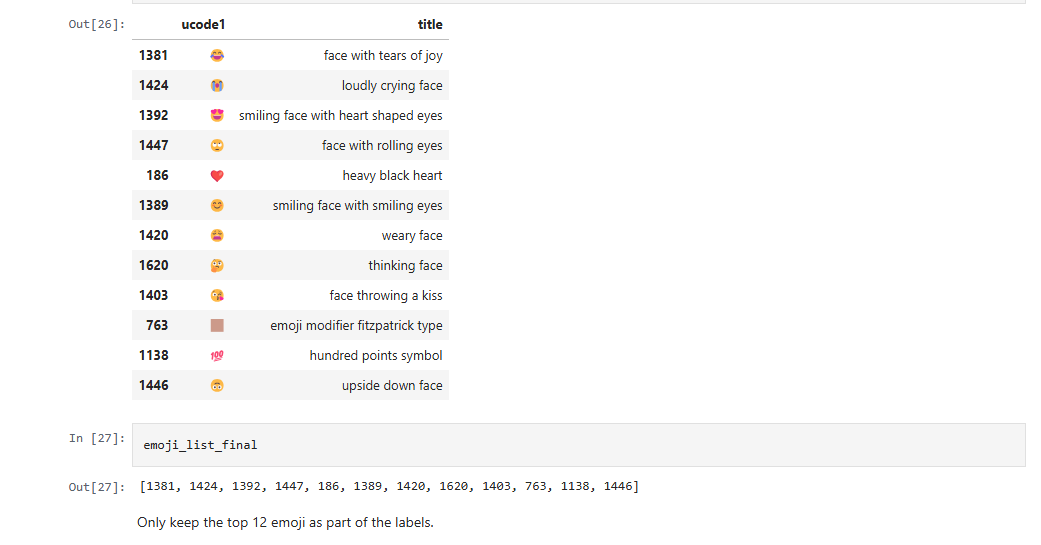

We ignore the emoji modifier.

<function matplotlib.pyplot.show(close=None, block=None)>

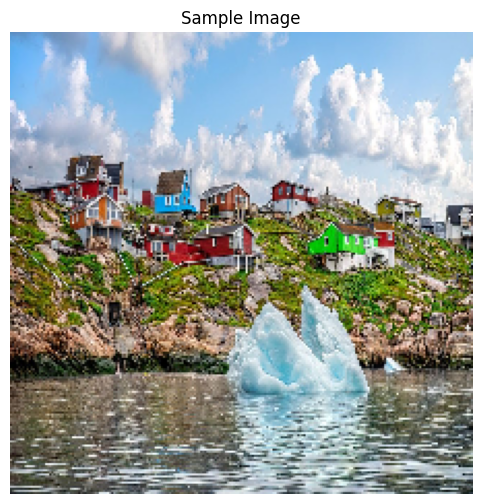

In [11]:

# Display the grayscale and edge images side by side
plt.figure(figsize=(12, 6))
            
# Grayscale Image
plt.imshow(rgb_arr)
plt.title("Sample Image")
plt.axis('off')
            
plt.show